<a href="https://colab.research.google.com/github/twelvesense/first-repository/blob/master/ExplNode16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#프로젝트 : Segmentation map으로 도로 이미지 만들기

#1: 기본 준비

##1.1: 데이터 준비

In [1]:
# 디렉토리
from google.colab import drive
drive.mount('/content/drive')
colab_dir = '/content/drive/MyDrive/colab/ExplNode16'

Mounted at /content/drive


In [64]:
weight_path = colab_dir + '/data/gan/GAN_500'
weight_path = colab_dir + '/data/cgan/CGAN_500'
# data_path = colab_dir + '/data/data/pokemon_pix2pix_dataset/train/'
data_path = colab_dir
data_train_path = colab_dir + '/data/cityscapes/train/'
data_val_path = colab_dir + '/data/cityscapes/val/'

In [2]:
# pip list | grep tensorflow-dataset
!pip list | grep tensorflow-dataset

tensorflow-datasets           4.0.1


##1.2: 모듈 준비

In [59]:
import tensorflow_datasets as tfds
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, Input, Model
from tensorflow.keras import optimizers, losses
from tensorflow import image
from tensorflow import data
from tensorflow.keras.preprocessing.image import random_rotation
import numpy as np
import os
import cv2

In [6]:
# GAN과 cGAN 각각을 실험해 보기 위해 label 정보 사용 유무에 따라 gan_preprocessing()과 cgan_preprocessing() 두 가지 함수를 구성
BATCH_SIZE = 128

def gan_preprocessing(data):
    image = data["image"]
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1
    return image

def cgan_preprocessing(data):
    image = data["image"]
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1
    
    label = tf.one_hot(data["label"], 10)
    return image, label

gan_datasets = mnist.map(gan_preprocessing).shuffle(1000).batch(BATCH_SIZE)
cgan_datasets = mnist.map(cgan_preprocessing).shuffle(100).batch(BATCH_SIZE)

In [10]:
# GAN의 Generator
class GeneratorGAN(Model):
    def __init__(self):
        super(GeneratorGAN, self).__init__()

        self.dense_1 = layers.Dense(128, activation='relu')
        self.dense_2 = layers.Dense(256, activation='relu')
        self.dense_3 = layers.Dense(512, activation='relu')
        self.dense_4 = layers.Dense(28*28*1, activation='tanh')

        self.reshape = layers.Reshape((28, 28, 1))

    def call(self, noise):
        out = self.dense_1(noise)
        out = self.dense_2(out)
        out = self.dense_3(out)
        out = self.dense_4(out)
        return self.reshape(out)

In [11]:
# cGAN의 Generator
class GeneratorCGAN(Model):
    def __init__(self):
        super(GeneratorCGAN, self).__init__()
        
        self.dense_z = layers.Dense(256, activation='relu')
        self.dense_y = layers.Dense(256, activation='relu')
        self.combined_dense = layers.Dense(512, activation='relu')
        self.final_dense = layers.Dense(28 * 28 * 1, activation='tanh')
        self.reshape = layers.Reshape((28, 28, 1))

    def call(self, noise, label):
        noise = self.dense_z(noise)
        label = self.dense_y(label)
        out = self.combined_dense(tf.concat([noise, label], axis=-1))
        out = self.final_dense(out)
        return self.reshape(out)

In [12]:
# GAN의 Discriminator

class DiscriminatorGAN(Model):
    def __init__(self):
        super(DiscriminatorGAN, self).__init__()
        self.flatten = layers.Flatten()
        
        self.blocks = []
        for f in [512, 256, 128, 1]:
            self.blocks.append(
                layers.Dense(f, activation=None if f==1 else "relu")
            )
        
    def call(self, x):
        x = self.flatten(x)
        for block in self.blocks:
            x = block(x)
        return x

In [13]:
# Maxout
class Maxout(layers.Layer):
    def __init__(self, units, pieces):
        super(Maxout, self).__init__()
        self.dense = layers.Dense(units*pieces, activation="relu")
        self.dropout = layers.Dropout(.5)    
        self.reshape = layers.Reshape((-1, pieces, units))
    
    def call(self, x):
        x = self.dense(x)
        x = self.dropout(x)
        x = self.reshape(x)
        return tf.math.reduce_max(x, axis=2)

In [14]:
# Maxout 레이어 3번 사용한 cGAN의 Discriminator

class DiscriminatorCGAN(Model):
    def __init__(self):
        super(DiscriminatorCGAN, self).__init__()
        self.flatten = layers.Flatten()
        
        self.image_block = Maxout(240, 5)
        self.label_block = Maxout(50, 5)
        self.combine_block = Maxout(240, 4)
        
        self.dense = layers.Dense(1, activation=None)
    
    def call(self, image, label):
        image = self.flatten(image)
        image = self.image_block(image)
        label = self.label_block(label)
        x = layers.Concatenate()([image, label])
        x = self.combine_block(x)
        return self.dense(x)

In [17]:
# loss함수: Binary Cross Entropy
bce = losses.BinaryCrossentropy(from_logits=True)

def generator_loss(fake_output):
    return bce(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    return bce(tf.ones_like(real_output), real_output) + bce(tf.zeros_like(fake_output), fake_output)

# Adam optimizer로 학습
gene_opt = optimizers.Adam(1e-4)
disc_opt = optimizers.Adam(1e-4)    

In [24]:
# gan_step()
@tf.function()
def gan_step(real_images):
    noise = tf.random.normal([real_images.shape[0], 100])
    
    with tf.GradientTape(persistent=True) as tape:
        # Generator를 이용해 가짜 이미지 생성
        fake_images = gan_generator(noise)
        # Discriminator를 이용해 진짜 및 가짜이미지를 각각 판별
        real_out = gan_discriminator(real_images)
        fake_out = gan_discriminator(fake_images)
        # 각 손실(loss)을 계산
        gene_loss = generator_loss(fake_out)
        disc_loss = discriminator_loss(real_out, fake_out)
    # gradient 계산
    gene_grad = tape.gradient(gene_loss, gan_generator.trainable_variables)
    disc_grad = tape.gradient(disc_loss, gan_discriminator.trainable_variables)
    # 모델 학습
    gene_opt.apply_gradients(zip(gene_grad, gan_generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_grad, gan_discriminator.trainable_variables))
    return gene_loss, disc_loss

In [25]:
#cgan_step()
@tf.function()
def cgan_step(real_images, labels):
    noise = tf.random.normal([real_images.shape[0], 100])
    
    with tf.GradientTape(persistent=True) as tape:
        fake_images = cgan_generator(noise, labels)
        
        real_out = cgan_discriminator(real_images, labels)
        fake_out = cgan_discriminator(fake_images, labels)
        
        gene_loss = generator_loss(fake_out)
        disc_loss = discriminator_loss(real_out, fake_out)
    
    gene_grad = tape.gradient(gene_loss, cgan_generator.trainable_variables)
    disc_grad = tape.gradient(disc_loss, cgan_discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_grad, cgan_generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_grad, cgan_discriminator.trainable_variables))
    return gene_loss, disc_loss

In [35]:
def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    sketch = img[:, :w, :] 
    sketch = tf.cast(sketch, tf.float32)
    colored = img[:, w:, :] 
    colored = tf.cast(colored, tf.float32)
    return normalize(sketch), normalize(colored)

In [38]:
# 학습에 사용하는 데이터의 다양성을 높이기 위해 여러 augmentation 방법을 적용

@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용합니다. 
def apply_augmentation(sketch, colored):
    stacked = tf.concat([sketch, colored], axis=-1)
    
    _pad = tf.constant([[30,30],[30,30],[0,0]])
    if tf.random.uniform(()) < .5:
        padded = tf.pad(stacked, _pad, "REFLECT")
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)

    out = image.random_crop(padded, size=[256, 256, 6])
    
    out = image.random_flip_left_right(out)
    out = image.random_flip_up_down(out)
    
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree)
    
    return out[...,:3], out[...,3:]  

In [41]:
# 학습 데이터 시각화 관련
def get_train(img_path):
    sketch, colored = load_img(img_path)
    sketch, colored = apply_augmentation(sketch, colored)
    return sketch, colored

In [43]:
# Generator의 Encoder 부분
class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu = layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)        

In [45]:
# Encoder
class Encoder(layers.Layer):
    def __init__(self):
        super(Encoder, self).__init__()
        filters = [64,128,256,512,512,512,512,512]
        
        self.blocks = []
        for i, f in enumerate(filters):
            if i == 0:
                self.blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.blocks.append(EncodeBlock(f))
    
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
    
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

In [47]:
# Decoder
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)
    
class Decoder(layers.Layer):
    def __init__(self):
        super(Decoder, self).__init__()
        filters = [512,512,512,512,256,128,64]
        
        self.blocks = []
        for i, f in enumerate(filters):
            if i < 3:
                self.blocks.append(DecodeBlock(f))
            else:
                self.blocks.append(DecodeBlock(f, dropout=False))
                
        self.blocks.append(layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False))
        
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
            
    def get_summary(self, input_shape=(1,1,512)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

In [49]:
# tf.keras.Model을 상속받아 Encoder와 Decoder를 연결한 Generator
class EncoderDecoderGenerator(Model):
    def __init__(self):
        super(EncoderDecoderGenerator, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def call(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
   
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

In [51]:
# U-Net Generator
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1]
                    
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

In [56]:
# DiscBlock
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 

In [55]:
# Discriminator
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.block1 = layers.Concatenate()
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        self.sigmoid = layers.Activation("sigmoid")
        
        # filters = [64,128,256,512,1]
        # self.blocks = [layers.Concatenate()]
        # for i, f in enumerate(filters):
        #     self.blocks.append(DiscBlock(
        #         n_filters=f,
        #         strides=2 if i<3 else 1,
        #         custom_pad=False if i<3 else True,
        #         use_bn=False if i==0 and i==4 else True,
        #         act=True if i<4 else False
        #     ))
    
    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()

In [60]:
# 두 가지 손실 함수
bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

In [61]:
# 사용할 optimizer (논문과 동일)
gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

In [62]:
# train_step
@tf.function
def train_step(sketch, real_colored):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_colored = generator(sketch, training=True)
        # Discriminator 예측
        fake_disc = discriminator(sketch, fake_colored, training=True)
        real_disc = discriminator(sketch, real_colored, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_colored, real_colored, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

# 2: 데이터 준비하기

* 데이터 분석

In [66]:
print("number of train examples :", len(os.listdir(data_train_path)))

number of train examples : 1000


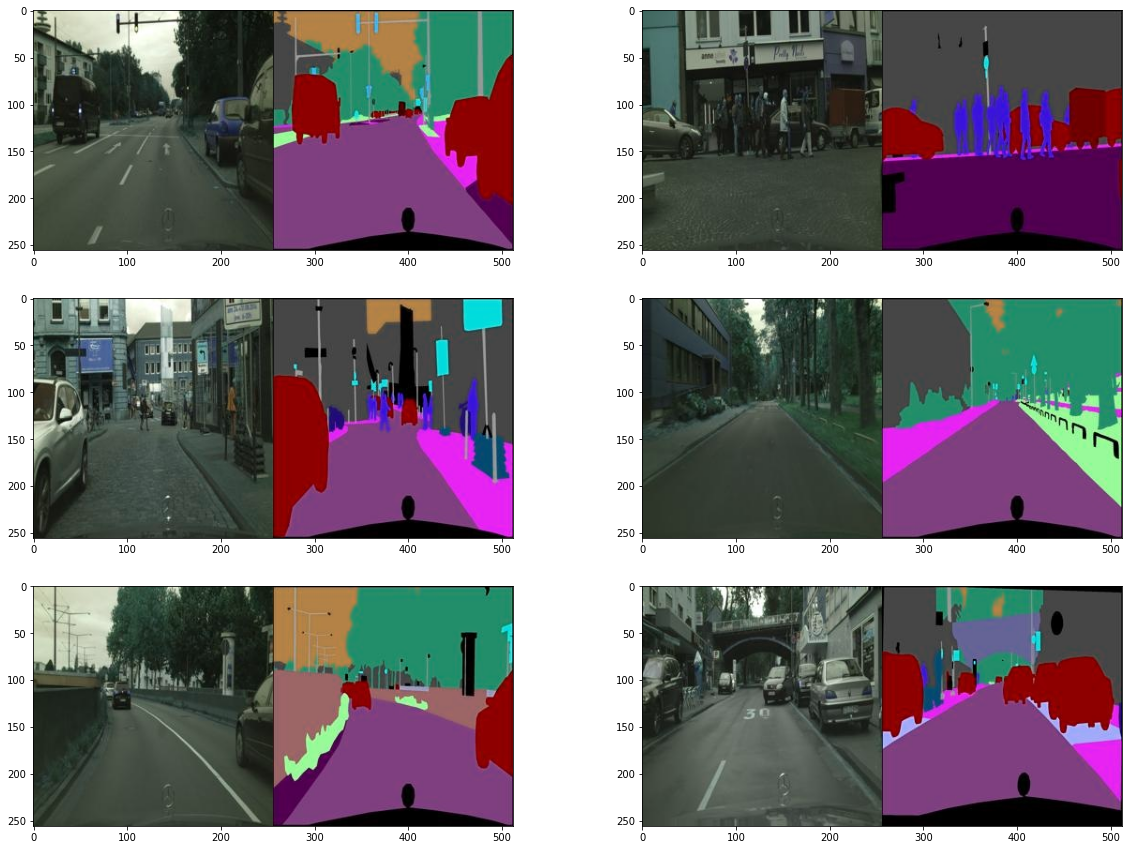

In [68]:
# 학습용 데이터셋에서 임의로 6장 확인하기
plt.figure(figsize=(20,15))
for i in range(1, 7):
    f = data_train_path + os.listdir(data_train_path)[np.random.randint(800)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3,2,i)
    plt.imshow(img)

In [69]:
# 이미지 크기 확인
f = data_train_path + os.listdir(data_train_path)[0]
img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)

(256, 512, 3)


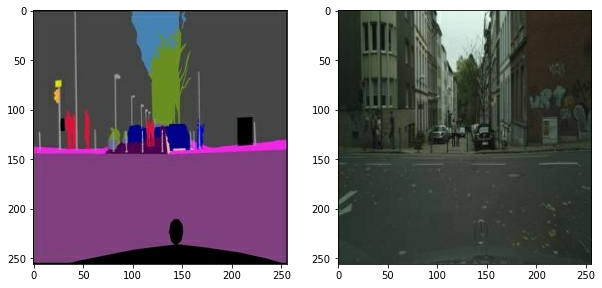

In [88]:
# 이미지 나누기
f = data_train_path + os.listdir(data_train_path)[1]
ori, seg = load_img(f)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(denormalize(seg))
plt.subplot(1,2,2); plt.imshow(denormalize(ori))

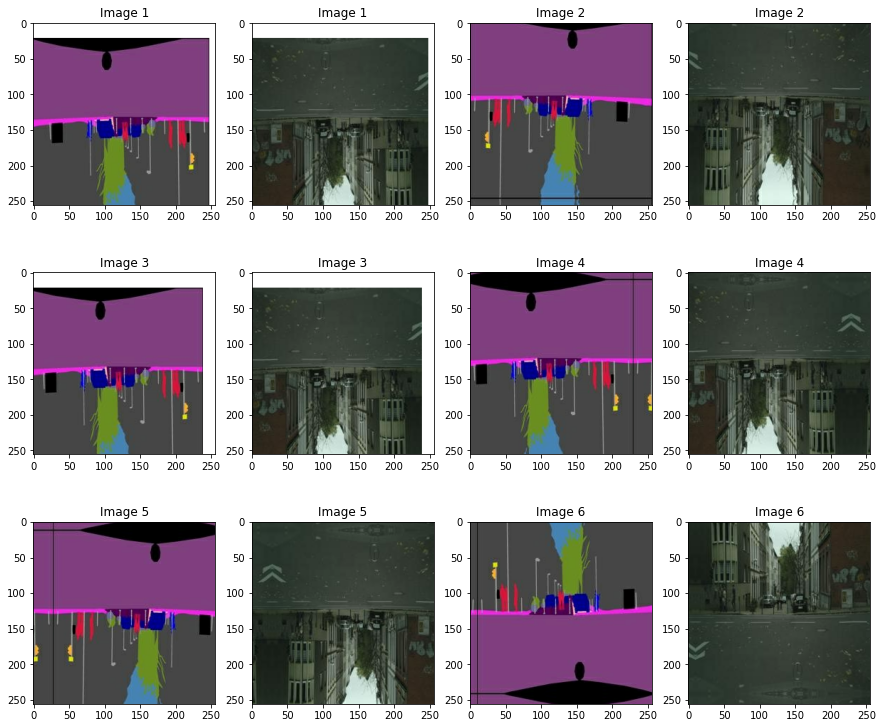

In [81]:
# 데이터 시각화
plt.figure(figsize=(15,13))
img_n = 1
for i in range(1, 13, 2):
    augmented_ori, augmented_seg = apply_augmentation(ori, seg)
    
    plt.subplot(3,4,i)
    plt.imshow(denormalize(augmented_seg)); plt.title(f"Image {img_n}")
    plt.subplot(3,4,i+1); 
    plt.imshow(denormalize(augmented_ori)); plt.title(f"Image {img_n}")
    img_n += 1

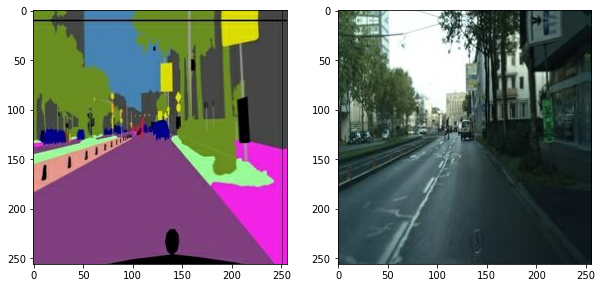

In [86]:
train_images = data.Dataset.list_files(data_train_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)

sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
ori, seg = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(seg[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(ori[0].astype(np.uint8))

# 3: Generator 구성하기

In [73]:
# skip connection이 있는 U-Net 구조 Generator

UNetGenerator().get_summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 encode_block_32 (EncodeBlock)  (None, 128, 128, 64  3072        ['input_8[0][0]']                
                                )                                                                 
                                                                                                  
 encode_block_33 (EncodeBlock)  (None, 64, 64, 128)  131584      ['encode_block_32[0][0]']        
                                                                                            

# 4: Discriminator 구성하기

In [74]:
# 각 출력의 크기가 맞는지 확인하기
inputs = Input((128,128,32))
out = layers.ZeroPadding2D()(inputs)
out = layers.Conv2D(64, 4, 1, "valid", use_bias=False)(out)
out = layers.BatchNormalization()(out)
out = layers.LeakyReLU(0.2)(out)

Model(inputs, out).summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 128, 128, 32)]    0         
                                                                 
 zero_padding2d_7 (ZeroPaddi  (None, 130, 130, 32)     0         
 ng2D)                                                           
                                                                 
 conv2d_56 (Conv2D)          (None, 127, 127, 64)      32768     
                                                                 
 batch_normalization_85 (Bat  (None, 127, 127, 64)     256       
 chNormalization)                                                
                                                                 
 leaky_re_lu_53 (LeakyReLU)  (None, 127, 127, 64)      0         
                                                                 
Total params: 33,024
Trainable params: 32,896
Non-trainable

In [75]:
# 각 블록의 출력 크기 확인하기
Discriminator().get_summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_11 (InputLayer)          [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 concatenate_17 (Concatenate)   (None, 256, 256, 6)  0           ['input_10[0][0]',               
                                                                  'input_11[0][0]']         

# 5: 학습 및 테스트하기

In [89]:
# 10 epoch 학습하기
EPOCHS = 10

generator = UNetGenerator()
discriminator = Discriminator()

history_train = {'Generator_loss':[],'L1_loss':[],'Discriminator_loss':[]}

for epoch in range(1, EPOCHS+1):
    for i, (seg, ori) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(seg, ori)
        if i == 0:
            history_train['Generator_loss'].append(g_loss)
            history_train['L1_loss'].append(l1_loss)
            history_train['Discriminator_loss'].append(d_loss)
      
        # 10회 반복마다 손실을 출력합니다.
        if (i+1) % 10 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[1] - STEP[10]                     
Generator_loss:1.0982                     
L1_loss:0.2042                     
Discriminator_loss:0.5177

EPOCH[1] - STEP[20]                     
Generator_loss:1.8882                     
L1_loss:0.1499                     
Discriminator_loss:1.1252

EPOCH[1] - STEP[30]                     
Generator_loss:2.4112                     
L1_loss:0.1869                     
Discriminator_loss:0.4101

EPOCH[1] - STEP[40]                     
Generator_loss:2.5193                     
L1_loss:0.1649                     
Discriminator_loss:1.9747

EPOCH[1] - STEP[50]                     
Generator_loss:3.2666                     
L1_loss:0.1546                     
Discriminator_loss:0.8704

EPOCH[1] - STEP[60]                     
Generator_loss:1.6413                     
L1_loss:0.1581                     
Discriminator_loss:1.0471

EPOCH[1] - STEP[70]                     
Generator_loss:1.0403                     
L1_loss:0.1647                    

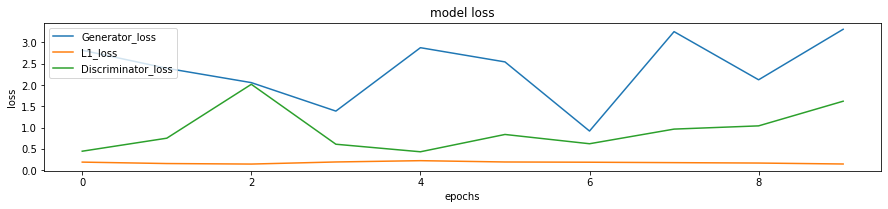

In [90]:
# summarize history for loss  
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

plt.subplot(211)  
plt.plot(history_train['Generator_loss'])  
plt.plot(history_train['L1_loss'])  
plt.plot(history_train['Discriminator_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epochs')  
plt.legend(['Generator_loss', 'L1_loss', 'Discriminator_loss'], loc='upper left')  

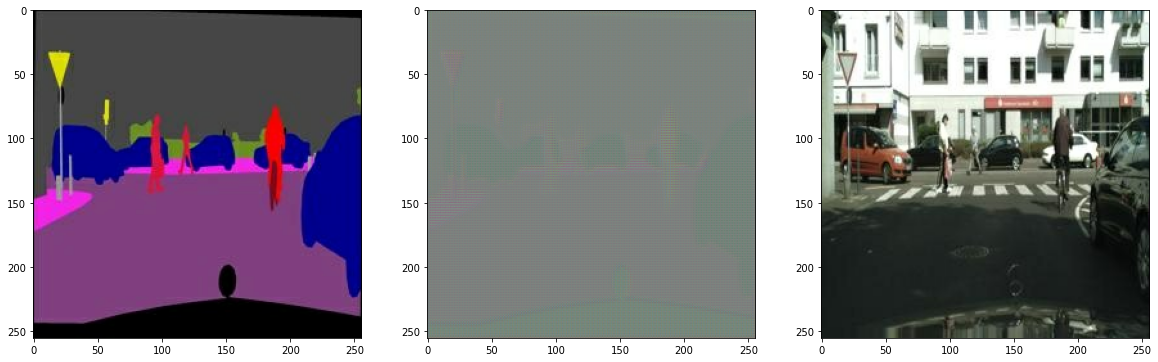

In [91]:
# 첫번째 채색
test_ind = 1
f = data_val_path + os.listdir(data_val_path)[test_ind]
ori, seg = load_img(f)

pred = generator(tf.expand_dims(seg, 0))
pred = denormalize(pred)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.imshow(denormalize(seg))
plt.subplot(1,3,2); plt.imshow(pred[0])
plt.subplot(1,3,3); plt.imshow(denormalize(ori))

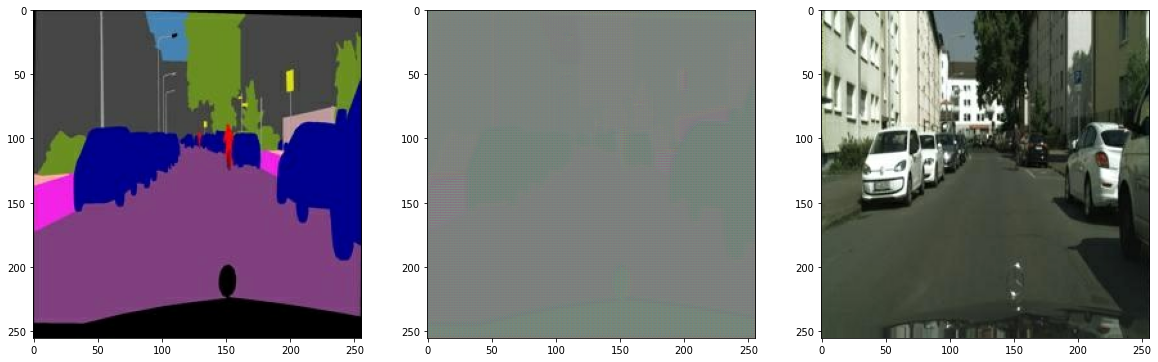

In [92]:
# 두번째 채색
test_ind = 2
f = data_val_path + os.listdir(data_val_path)[test_ind]
ori, seg = load_img(f)

pred = generator(tf.expand_dims(seg, 0))
pred = denormalize(pred)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.imshow(denormalize(seg))
plt.subplot(1,3,2); plt.imshow(pred[0])
plt.subplot(1,3,3); plt.imshow(denormalize(ori))

#회고

* skip connection이 있는 U-Net Generator PIX2PIX 모델을 경험할 수 있었다.
* 하지만, 이번 시도에서는 성능이 만족스럽지 못했다.
* 아마도, 데이터가 1000개 뿐이어서, 학습에 충분한 크기가 아닌 듯하다.
* 그래서, 데이터에 augmentation 방법들(refection padding, constant padding)을 적용해 보았다.